In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,StratifiedKFold
from sklearn.preprocessing import Binarizer

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score,precision_score,roc_auc_score
from sklearn.metrics import precision_recall_curve,roc_curve,confusion_matrix , auc

In [2]:
def model_basic(x_train, y_train, x_test, y_test): 
    models = [
        LogisticRegression(),
        LinearDiscriminantAnalysis(),
        GaussianNB(),
        RandomForestClassifier(),
        XGBClassifier()
    ]

    rdict={'model':[],'acc_train':[], 'auc_train':[], 'acc_test':[],'precision':[],'recall':[],'f1_score':[], 'AUC_test':[]}


    for clf in models:
        clf = clf.fit(x_train, y_train)
    #1열:Train
        y_hat = clf.predict(x_train)
        results_train  = (round(accuracy_score(y_train,y_hat),2),round(roc_auc_score(y_train,y_hat),2))
    #2열:Test
        y_hat = clf.predict(x_test)
        results = (round(accuracy_score(y_test,y_hat),2),
                        round(precision_score(y_test,y_hat),2),
                        round(recall_score(y_test,y_hat),2),
                        round(f1_score(y_test,y_hat),2),
                        round(roc_auc_score(y_test,y_hat),2))

        rdict['model'].append(clf); 
        rdict['acc_train'].append(results_train[0])
        rdict['auc_train'].append(results_train[1])
        
        rdict['acc_test'].append(results[0])
        rdict['precision'].append(results[1])
        rdict['recall'].append(results[2])
        rdict['f1_score'].append(results[3])
        rdict['AUC_test'].append(results[4])   

        confusion = confusion_matrix(y_test, y_hat)

        print(confusion)

    rdf_final = pd.DataFrame(data=rdict)
    return rdf_final

In [3]:
def eval(test,pred):
    acc = accuracy_score(test,pred)
    f1 = f1_score(test,pred)
    precision = precision_score(test,pred)
    recall = recall_score(test,pred)
    print('##############\n',confusion_matrix(test,pred),
    "############\n",f'acc_score: {acc}\n f1_score: {f1} \n precision: {precision} \n recall: {recall}')

## 임계값 =[] 리스트생성 후 for 구문
def get_eval_by_threshold(y_test , pred_proba_c1, thresholds=[0.5,0.52,0.54,0.56,0.58,0.6,0.62]):
    # thresholds list객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        eval(y_test , custom_predict)


def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    

## roc curve_plot    
def roc_curve_plot(y_test,pred_proba):
    fprs, tprs, thresholds = roc_curve(y_test,pred_proba) ## 입력시 1레이블 컬럼만 추출
    
    # Roc curve를 plot 곡선으로 기름
    plt.plot(fprs,tprs,label='ROC')
    ## 가운데 대각선 직선을 그림
    plt.plot([0,1],[0,1],"k--",label="ramdom")
    
    ## fpr x축을 scale을 0.1단위로 변경 x,y축 명 설정
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR(1-sensitivity)')
    plt.ylabel('TPR(recall)')
    plt.legend()
    plt.show()

In [4]:
def plot_pr_auc_curve(y_true, y_pred_proba):
    # Calculate precision, recall and threshold values
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    # Calculate PR-AUC score
    pr_auc = auc(recall, precision)
    # Plot the PR-AUC curve
    plt.plot(recall, precision, label=f'PR-AUC = {pr_auc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR-AUC Curve')
    plt.legend()
    plt.show()

def get_pr_auc_score(y_true, y_pred_proba):
    # Calculate precision, recall and threshold values
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    # Calculate PR-AUC score
    pr_auc = auc(recall, precision)
    return pr_auc

In [5]:
## 불균형 처리 안한 데이터 
train = pd.read_csv("./datasets/통계검증완료/코스피_standard_train.csv", index_col=0)
test = pd.read_csv("./datasets/통계검증완료/코스피_standard_test.csv", index_col=0)


최종_col_1= ['EBITDA마진율', '누적수익성비율', 'TMD', '자기자본순이익률', '금융비용부담률', '정상영업이익증가율']

train_x = train[최종_col_1]
train_y = train["target_3"]

test_x = test[최종_col_1]
test_y = test["target_3"]

In [6]:
# # 불균형 처리한 후 데이터
# train = pd.read_csv('./datasets/불균형처리/boder_코스피_standard_train.csv',index_col=0)
# train_x = train.drop(['target_3'],axis=1)
# train_y = train['target_3']

# test = pd.read_csv('./datasets/불균형처리/코스피_standard_test.csv',index_col=0)
# test_x = test.drop(['회사명','거래소코드','회계년도','산업군','target_3'],axis=1)
# test_y = test['target_3']

## random과grid차이
- random은 넓은 범위에 하이퍼파라미터를 찾을때 효율적 랜덤한 조합으로 학습시키기때문 - 그러나 어떤조합은 적합시키지 않을수있음 그러므로 반복횟수를 적절하게 조절하는것이필요
- grid는 모든경우에 수를 적합시킴 그러므로 조합의 수가 많아진다면 시간이 오래걸리기때문에 오히려 random으로했을때 시간적으로 효율적일 수 있음
------------------------------------

## LOGISTIC

In [29]:
lr=LogisticRegression(random_state=1,n_jobs=-1)
param = {
    'solver' :['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'C': [0.0001,0.001, 0.01,0.05, 0.1,0.5, 1, 10, 100,500],
    'penalty': ['l2'],
    'max_iter':[100,170,180,200],
    'fit_intercept' : [True,False],
    'class_weight': ['balanced',None]
}

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
grid_lr = GridSearchCV(lr,n_jobs=-1,scoring='f1',cv=cv,param_grid=param,refit=True)
grid_lr.fit(train_x,train_y)

scores_df = pd.DataFrame(grid_lr.cv_results_)
print(scores_df.iloc[:,4:])

    param_C param_class_weight param_fit_intercept param_max_iter  \
0    0.0001           balanced                True            100   
1    0.0001           balanced                True            100   
2    0.0001           balanced                True            100   
3    0.0001           balanced                True            100   
4    0.0001           balanced                True            100   
..      ...                ...                 ...            ...   
955     500               None               False            200   
956     500               None               False            200   
957     500               None               False            200   
958     500               None               False            200   
959     500               None               False            200   

    param_penalty     param_solver  \
0              l2            lbfgs   
1              l2        liblinear   
2              l2        newton-cg   
3              l2  

c:\Users\msi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


In [25]:
print(grid_lr.best_params_)
pred_lr = grid_lr.predict(test_x)
pred_prob = grid_lr.predict_proba(test_x)[:,1].reshape(-1,1)
eval(pred=pred_lr,test=test_y)

{'C': 0.0001, 'class_weight': None, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
##############
 [[1648    0]
 [   4    2]] ############
 acc_score: 0.9975816203143894
 f1_score: 0.5 
 precision: 1.0 
 recall: 0.3333333333333333


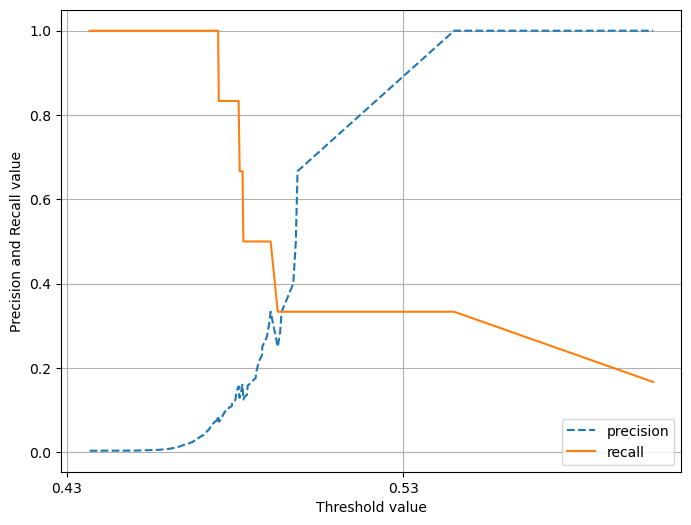

In [26]:
precision_recall_curve_plot(test_y,pred_prob)

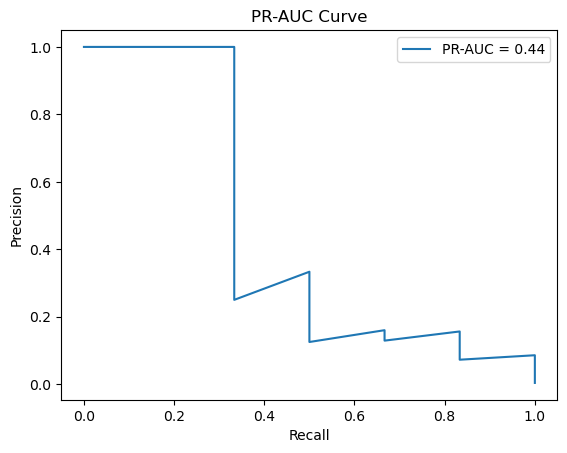

0.44264947043567304

In [27]:
plot_pr_auc_curve(test_y,pred_prob)
get_pr_auc_score(test_y,pred_prob)

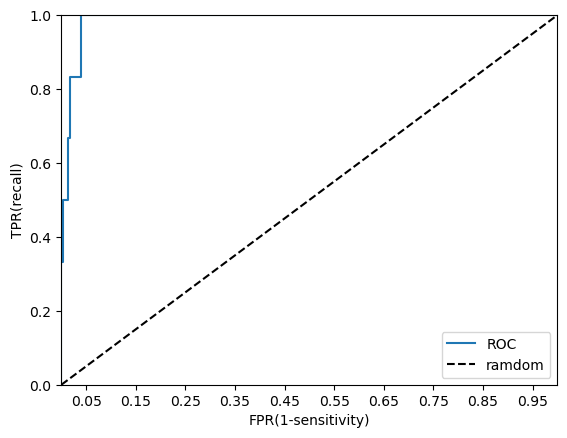

auc 값: 0.9881


In [28]:
## roc 커브 auc 값
roc_curve_plot(test_y,pred_prob)
auc_score = roc_auc_score(test_y,pred_prob)
print(f'auc 값: {np.round(auc_score,4)}')

## LDA

In [53]:
train_y.value_counts(property)

0.0    0.666667
1.0    0.333333
Name: target_3, dtype: float64

In [54]:
lda = LinearDiscriminantAnalysis(priors=[0.666667,0.333333],n_components=True)
param = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None,'auto',0.1,0.01,0.001,10]
}

grid_lda = GridSearchCV(lda, param_grid=param, scoring='f1', cv=5, n_jobs=-1, refit=True)
grid_lda.fit(train_x, train_y)

scores_df = pd.DataFrame(grid_lda.cv_results_)
print(scores_df.loc[:, 'param_solver':'mean_test_score'])


   param_solver                                    params  split0_test_score  \
0           svd      {'shrinkage': None, 'solver': 'svd'}           0.955090   
1          lsqr     {'shrinkage': None, 'solver': 'lsqr'}           0.955090   
2         eigen    {'shrinkage': None, 'solver': 'eigen'}           0.955090   
3           svd    {'shrinkage': 'auto', 'solver': 'svd'}                NaN   
4          lsqr   {'shrinkage': 'auto', 'solver': 'lsqr'}           0.955090   
5         eigen  {'shrinkage': 'auto', 'solver': 'eigen'}           0.955090   
6           svd       {'shrinkage': 0.1, 'solver': 'svd'}                NaN   
7          lsqr      {'shrinkage': 0.1, 'solver': 'lsqr'}           0.952096   
8         eigen     {'shrinkage': 0.1, 'solver': 'eigen'}           0.952096   
9           svd      {'shrinkage': 0.01, 'solver': 'svd'}                NaN   
10         lsqr     {'shrinkage': 0.01, 'solver': 'lsqr'}           0.955090   
11        eigen    {'shrinkage': 0.01, '

c:\Users\msi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
35 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\msi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\msi\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py", line 615, in fit
    raise NotImplementedError("shrinkage not supported with 'svd' solver.")
NotImplementedError: shrinkage not supported with 'svd' solver.

------------------------------------------------------------------------

In [55]:
print(grid_lda.best_params_)
pred_lda = grid_lda.predict(test_x)
pred_prob = grid_lda.predict_proba(test_x)[:,1].reshape(-1,1)
eval(pred=pred_lda,test=test_y)

{'shrinkage': None, 'solver': 'svd'}
##############
 [[1937   80]
 [   0    6]] ############
 acc_score: 0.9604547701433515
 f1_score: 0.13043478260869565 
 precision: 0.06976744186046512 
 recall: 1.0


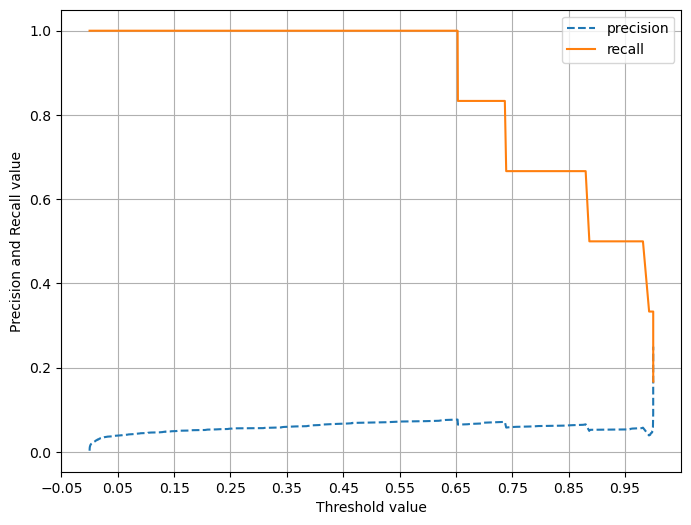

In [56]:
precision_recall_curve_plot(test_y,pred_prob)

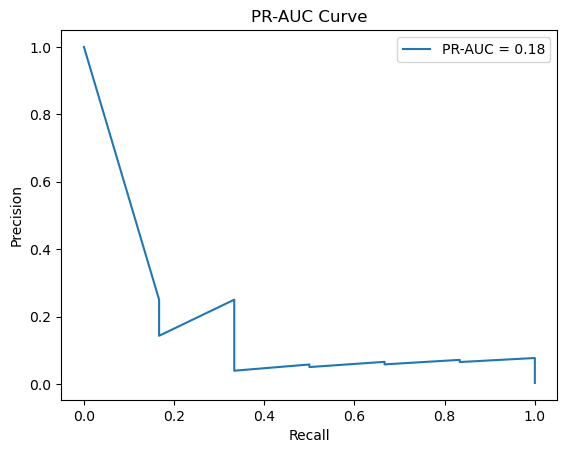

0.17721638625793584

In [57]:
plot_pr_auc_curve(test_y,pred_prob)
get_pr_auc_score(test_y,pred_prob)

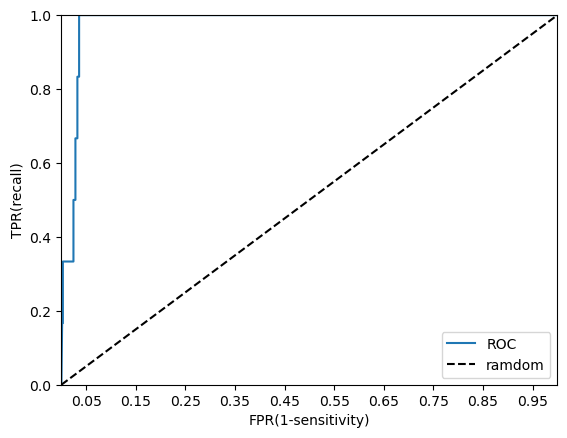

auc 값: 0.9793


In [58]:
## roc 커브 auc 값
roc_curve_plot(test_y,pred_prob)
auc_score = roc_auc_score(test_y,pred_prob)
print(f'auc 값: {np.round(auc_score,4)}')

## Gaussian_NB

In [59]:
train_y.value_counts(property)

0.0    0.666667
1.0    0.333333
Name: target_3, dtype: float64

In [60]:
nb=GaussianNB(priors=[0.666667,0.333333])

nb.fit(train_x,train_y)

pred = nb.predict(test_x)
pred_prob = nb.predict_proba(test_x)[:,1].reshape(-1,1)
eval(pred=pred,test=test_y)

##############
 [[1842  175]
 [   0    6]] ############
 acc_score: 0.9134948096885813
 f1_score: 0.06417112299465241 
 precision: 0.03314917127071823 
 recall: 1.0


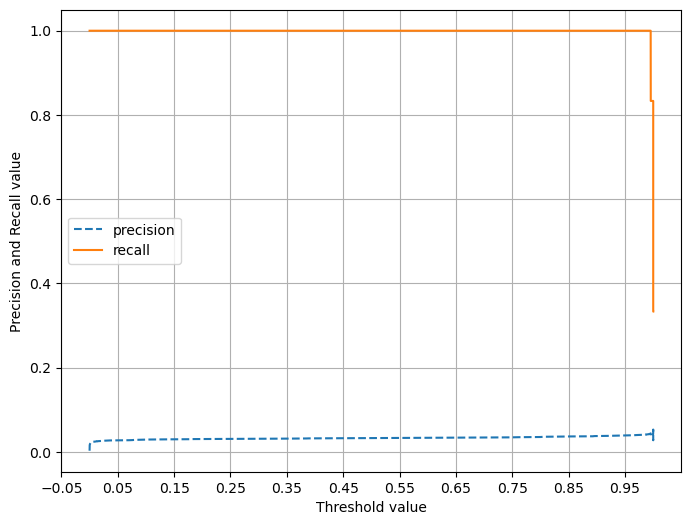

In [61]:
precision_recall_curve_plot(test_y,pred_prob)

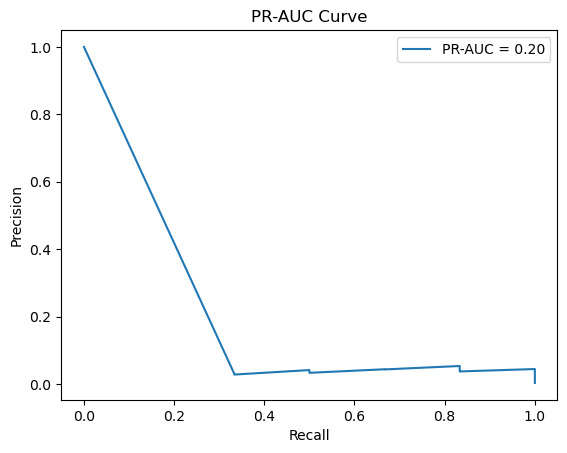

0.19860682906476085

In [62]:
plot_pr_auc_curve(test_y,pred_prob)
get_pr_auc_score(test_y,pred_prob)

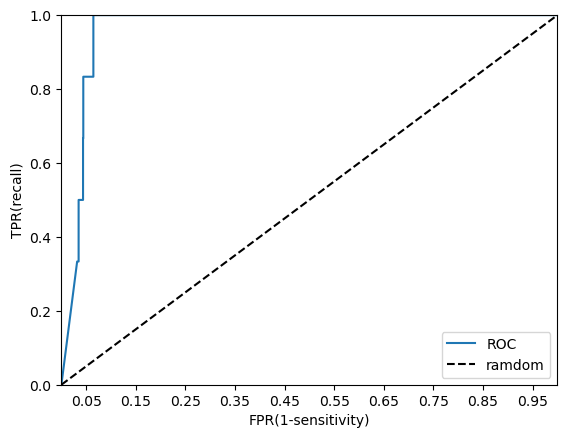

auc 값: 0.9636


In [63]:
## roc 커브 auc 값
roc_curve_plot(test_y,pred_prob)
auc_score = roc_auc_score(test_y,pred_prob)
print(f'auc 값: {np.round(auc_score,4)}')

## RandomForest

In [64]:
rf=RandomForestClassifier(random_state=1,n_jobs=-1)
param = {
    'class_weight' :['balanced_subsample','balanced'],
    'n_estimators': [50, 100, 200],
    'max_depth': [3,5,7,10 ],
    'min_samples_split': [2, 5,7, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_rf = GridSearchCV(rf,n_jobs=-1,scoring='f1',cv=5,param_grid=param,refit=True)
grid_rf.fit(train_x,train_y)

scores_df = pd.DataFrame(grid_rf.cv_results_)
print(scores_df.iloc[:,4:])

c:\Users\msi\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


     param_class_weight param_max_depth param_max_features  \
0    balanced_subsample               3               auto   
1    balanced_subsample               3               auto   
2    balanced_subsample               3               auto   
3    balanced_subsample               3               auto   
4    balanced_subsample               3               auto   
..                  ...             ...                ...   
859            balanced              10               log2   
860            balanced              10               log2   
861            balanced              10               log2   
862            balanced              10               log2   
863            balanced              10               log2   

    param_min_samples_leaf param_min_samples_split param_n_estimators  \
0                        1                       2                 50   
1                        1                       2                100   
2                        1          

In [65]:
print(grid_rf.best_params_)
pred = grid_rf.predict(test_x)
pred_prob = grid_rf.predict_proba(test_x)[:,1].reshape(-1,1)
eval(pred=pred,test=test_y)

{'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
##############
 [[1984   33]
 [   3    3]] ############
 acc_score: 0.9822046465645081
 f1_score: 0.14285714285714285 
 precision: 0.08333333333333333 
 recall: 0.5


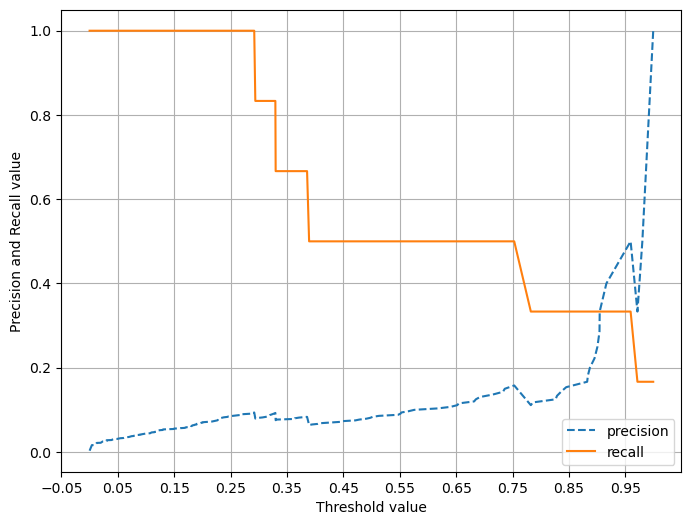

In [66]:
precision_recall_curve_plot(test_y,pred_prob)

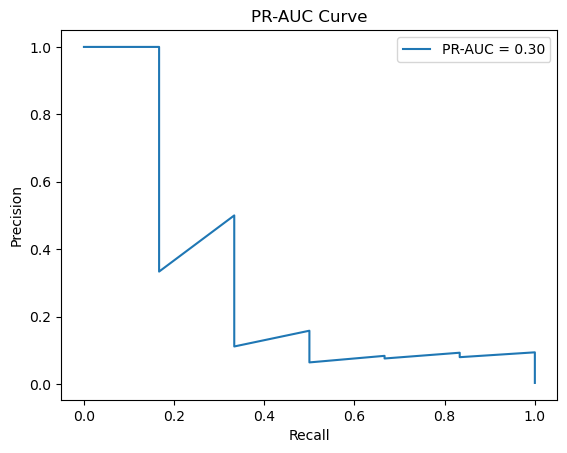

0.2992234726604004

In [67]:
plot_pr_auc_curve(test_y,pred_prob)
get_pr_auc_score(test_y,pred_prob)

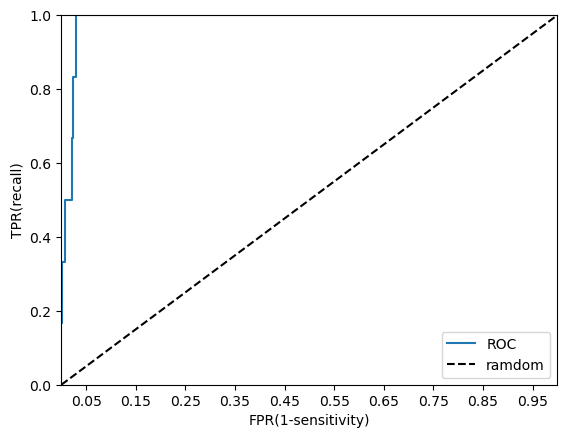

auc 값: 0.986


In [68]:
## roc 커브 auc 값
roc_curve_plot(test_y,pred_prob)
auc_score = roc_auc_score(test_y,pred_prob)
print(f'auc 값: {np.round(auc_score,4)}')

### xgboost

In [69]:
xgb = XGBClassifier(random_state=1, n_jobs=-1)
param = {
    'class_weight': ['balanced_subsample', 'balanced'],
    'n_estimators': [100, 200, 300],
    'max_depth': [ 7, 9,11],
    'min_child_weight': [1, 3],
    'subsample': [ 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'learning_rate': [ 0.01, 0.001],
}

grid_xgb = GridSearchCV(xgb, n_jobs=-1, scoring='f1', cv=5, param_grid=param, refit=True)
grid_xgb.fit(train_x, train_y)

scores_df = pd.DataFrame(grid_xgb.cv_results_)
print(scores_df.iloc[:, 4:])


[16:47:51] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

     param_class_weight param_colsample_bytree param_learning_rate  \
0    balanced_subsample                    0.7                0.01   
1    balanced_subsample                    0.7                0.01   
2    balanced_subsample                    0.7                0.01   
3    balanced_subsample                    0.7                0.01   
4    balanced_subsample                    0.7                0.01   
..                  ...                    ...                 ...   
427            balanced                    0.9               0.001   
428            balanced                    0.9               0.001   
429            balanced                    0.9               0.001   
430            balanced                    0.9               0.001   
431            balanced     

In [70]:
pred = grid_xgb.predict(test_x)
pred_prob = grid_xgb.predict_proba(test_x)[:,1].reshape(-1,1)
eval(pred=pred,test=test_y)

##############
 [[1987   30]
 [   2    4]] ############
 acc_score: 0.9841819080573406
 f1_score: 0.2 
 precision: 0.11764705882352941 
 recall: 0.6666666666666666


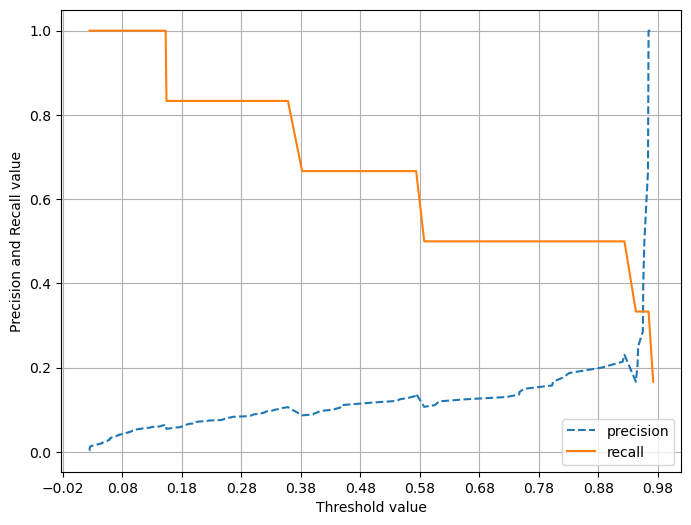

In [71]:
precision_recall_curve_plot(test_y,pred_prob)

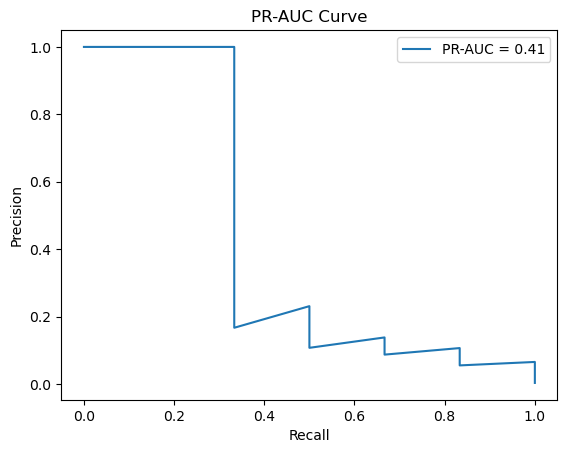

0.4130009779811209

In [72]:
plot_pr_auc_curve(test_y,pred_prob)
get_pr_auc_score(test_y,pred_prob)

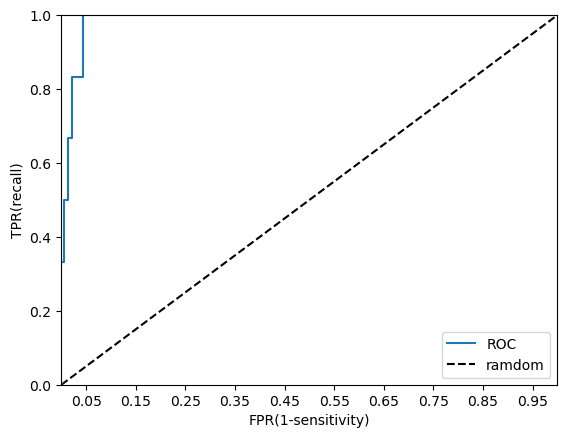

auc 값: 0.9865


In [73]:
## roc 커브 auc 값
roc_curve_plot(test_y,pred_prob)
auc_score = roc_auc_score(test_y,pred_prob)
print(f'auc 값: {np.round(auc_score,4)}')